<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle
import pdb

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Stocks LSTM Prediction

In [8]:
google_drive_path = 'drive/MyDrive/DL_Pickles/'
local_path = './pickles/'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"./{google_drive_path}/stock_data_processed_with_prev_days_data.pkl"

In [6]:
def calculate_rsi(group, period = 14):
    delta = group['close_adjusted'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / np.where(avg_loss != 0, avg_loss, 1)

    group['RSI'] = 100 - (100 / (1 + rs))

    return group

def calculate_macd(group, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = group['close_adjusted'].ewm(span=short_window, adjust=False).mean()
    ema_long = group['close_adjusted'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    group['MACD'] = ema_short - ema_long
    group['Signal_Line'] = group['MACD'].ewm(span=signal_window, adjust=False).mean()

    return group

In [15]:
def get_peak_price_and_days_ago(df):
    """
    Calculate the peak price over a rolling 90-day window and determine the number of days
    since the peak price for each row in the DataFrame.
    """

    #df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    #peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    #df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    print('Calculated RSI')
    # Calculate RSI (14-day by default)
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    print('Calculated moving averages')
    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200]  # Specify moving average windows
    for window in moving_average_windows:
        df[f'{window}_day_MA'] = df.groupby('ticker')['close_adjusted'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)

    print('Calculated MACD')
    # Calculate MACD and Signal Line

    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    print('Calculated price days ago')
    # Add columns for prices X days ago
    for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
        df[f'price_{days}_days_ago'] = df.groupby('ticker')['close_adjusted'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

In [16]:
def getTidiedStockData():
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.
    """

    # Check if the file exists
    if os.path.exists(stock_data_path):
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [17]:
stock_data_tidy = getTidiedStockData()

Calculated RSI


<ipython-input-15-530131de444b>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)


Calculated moving averages
Calculated MACD


<ipython-input-15-530131de444b>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker', group_keys=False).apply(calculate_macd)


Calculated price days ago


<ipython-input-15-530131de444b>:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)
<ipython-input-15-530131de444b>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)


In [18]:
stock_data_tidy.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'RSI', '5_day_MA', '10_day_MA', '20_day_MA', '50_day_MA',
       '100_day_MA', '200_day_MA', 'MACD', 'Signal_Line', 'price_1_days_ago',
       'price_2_days_ago', 'price_3_days_ago', 'price_4_days_ago',
       'price_5_days_ago', 'price_10_days_ago', 'price_15_days_ago',
       'price_30_days_ago', 'price_60_days_ago', 'price_90_days_ago',
       'ticker_encoded'],
      dtype='object')

In [19]:
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close', 'volume'])

In [20]:
stock_data_tidy['day_of_week'] = stock_data_tidy['date'].dt.dayofweek

In [21]:
def plot_stock_chart(stock_data_tidy, ticker, start_date=None, end_date=None):
    """
    Plot a stock chart for a specific ticker.

    Parameters:
        stock_data_tidy (DataFrame): The DataFrame containing stock data.
        ticker (str): The ticker to plot.
        start_date (str): Optional start date (e.g., '2023-01-01').
        end_date (str): Optional end date (e.g., '2023-12-31').
    """
    # Filter data for the specific ticker and date range
    stock_data_tidy['date'] = pd.to_datetime(stock_data_tidy['date'])
    filtered_data = stock_data_tidy[stock_data_tidy['ticker'] == ticker]

    if start_date:
        filtered_data = filtered_data[filtered_data['date'] >= start_date]
    if end_date:
        filtered_data = filtered_data[filtered_data['date'] <= end_date]

    # Ensure data is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # Plot the stock chart
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['date'], filtered_data['close_adjusted'], label='Close Price', color='blue', linewidth=2)

    # Add moving averages if they exist in the DataFrame
    for col in ['5_day_MA', '10_day_MA', '50_day_MA']:
        if col in filtered_data.columns:
            plt.plot(filtered_data['date'], filtered_data[col], label=col, linestyle='--')

    # Chart settings
    plt.title(f"Stock Chart for {ticker}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

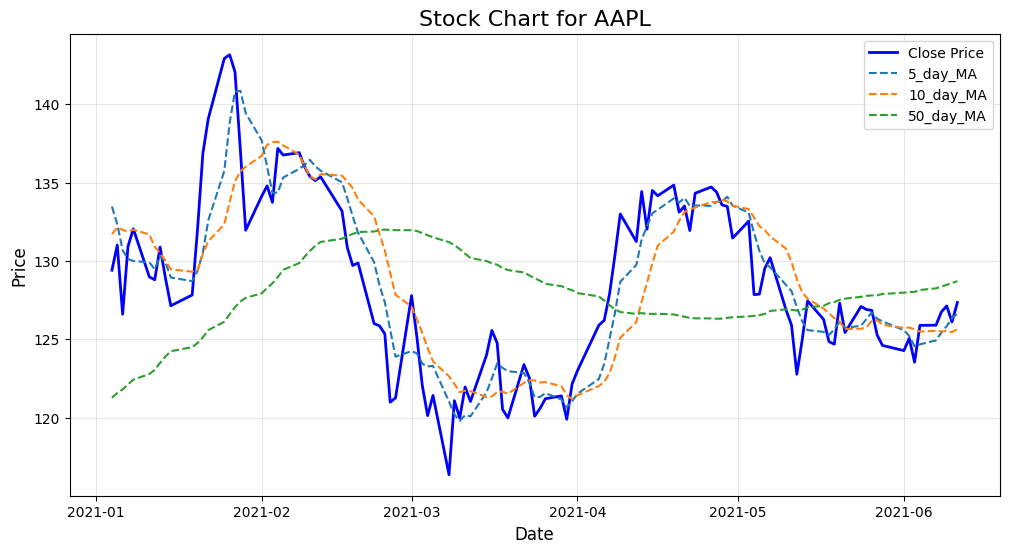

In [15]:
plot_stock_chart(stock_data_tidy, ticker='AAPL', start_date='2021-01-01', end_date='2022-12-31')

In [22]:
stock_data_tidy.columns

Index(['ticker', 'date', 'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
       '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA', 'MACD',
       'Signal_Line', 'price_1_days_ago', 'price_2_days_ago',
       'price_3_days_ago', 'price_4_days_ago', 'price_5_days_ago',
       'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
       'price_60_days_ago', 'price_90_days_ago', 'ticker_encoded',
       'day_of_week'],
      dtype='object')

In [23]:
numerical_columns = [
    'close_adjusted', 'RSI', '5_day_MA', '10_day_MA',
    '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
    'MACD', 'Signal_Line', 'day_of_week',
    'price_1_days_ago', 'price_2_days_ago',
    'price_3_days_ago', 'price_4_days_ago', 'price_5_days_ago',
    'price_10_days_ago', 'price_15_days_ago', 'price_30_days_ago',
    'price_60_days_ago', 'price_90_days_ago'
]

scaler = MinMaxScaler()

stock_data_tidy[numerical_columns] = scaler.fit_transform(stock_data_tidy[numerical_columns])

print(stock_data_tidy.head())

  ticker       date  close_adjusted       RSI      5_day_MA     10_day_MA  \
0      A 2000-09-05    3.928939e-08  0.848976  4.072033e-08  4.097881e-08   
1      A 2000-09-06    3.813939e-08  0.791929  4.032506e-08  4.094505e-08   
2      A 2000-09-07    3.933389e-08  0.783343  4.039094e-08  4.103822e-08   
3      A 2000-09-08    3.766287e-08  0.572143  4.016038e-08  4.100446e-08   
4      A 2000-09-11    3.607457e-08  0.397375  3.948450e-08  4.088631e-08   

      20_day_MA     50_day_MA    100_day_MA    200_day_MA  ...  \
0  3.684831e-08  4.661724e-08  6.408939e-08  7.443236e-08  ...   
1  3.758626e-08  4.637094e-08  6.380585e-08  7.453230e-08  ...   
2  3.837228e-08  4.615019e-08  6.360916e-08  7.462372e-08  ...   
3  3.907749e-08  4.582055e-08  6.341777e-08  7.472055e-08  ...   
4  3.963889e-08  4.550913e-08  6.313187e-08  7.480088e-08  ...   

   price_3_days_ago  price_4_days_ago  price_5_days_ago  price_10_days_ago  \
0      3.901617e-08      4.004550e-08      3.726897e-08       

In [28]:
unique_count = stock_data_tidy['ticker'].nunique()

In [29]:
def preprocess_data(stock_data_tidy, numerical_columns, sequence_length):
    data = stock_data_tidy[numerical_columns].values

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(data[i, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [40]:
from tensorflow.keras.layers import BatchNormalization

def create_lstm_model(sequence_length, num_features, lstm_units_1=256, lstm_units_2=128, lstm_units_3=64, dropout_rate=0.2):
    """
    Optimized LSTM model for stock price prediction.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    x = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1", dropout=dropout_rate)(numerical_input)
    x = BatchNormalization()(x)

    x = LSTM(lstm_units_2, return_sequences=True, name="lstm_layer_2", dropout=dropout_rate)(x)
    x = BatchNormalization()(x)

    x = LSTM(lstm_units_3, return_sequences=False, name="lstm_layer_3")(x)
    x = BatchNormalization()(x)

    x = Dense(64, activation='relu', name="dense_1")(x)

    output = Dense(32, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(x)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [41]:
lstm_model = create_lstm_model(sequence_length=30, num_features=len(numerical_columns))

In [42]:
lstm_model.summary()

Model: "Optimized_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)         │ (None, 30, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_1 (LSTM)                  │ (None, 30, 256)             │         284,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 30, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_2 (LSTM)                  │ (None, 30, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_3 (LSTM)                  │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 537,217 (2.05 MB)

 Trainable params: 536,321 (2.05 MB)

 Non-trainable params: 896 (3.50 KB)

In [47]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

processed_data_path = google_drive_path + 'processed_data_with_before_prices/'

def preprocess_grouped_data(stock_data_tidy, numerical_columns, target_column, sequence_length):
    tickers = stock_data_tidy["ticker_encoded"].unique()

    for ticker in tickers:
        ticker_data = stock_data_tidy[stock_data_tidy["ticker_encoded"] == ticker].sort_values(by="date")
        numerical_data = ticker_data[numerical_columns].values

        if(ticker % 1000 == 0):
          print('Processing ', ticker)
        if len(ticker_data) > sequence_length:
            x_ticker = sliding_window_view(numerical_data, window_shape=(sequence_length, len(numerical_columns)))
            x_ticker = x_ticker.reshape(-1, sequence_length, len(numerical_columns))

            y_ticker = ticker_data[target_column].values[sequence_length-1:]

            np.save(os.path.join(processed_data_path, f"x_ticker_{ticker}.npy"), x_ticker)
            np.save(os.path.join(processed_data_path, f"y_ticker_{ticker}.npy"), y_ticker)

In [49]:
if os.path.exists(processed_data_path) and os.path.isdir(processed_data_path):
    has_file = any(os.path.isfile(os.path.join(processed_data_path, item)) for item in os.listdir(processed_data_path))
    if has_file:
        print("There are files in the processed_data_path.")
    else:
      print('Beginning to process the data...\n')
      preprocess_grouped_data(stock_data_tidy, numerical_columns, 'close_adjusted', 30)
else:
    print("The processed_data_path does not exist or is not a directory.")

Beginning to process the data...

Processing  0
Processing  1000
Processing  2000
Processing  3000
Processing  4000
Processing  5000
Processing  6000
Processing  7000


In [50]:
# Create a list of tickers
x_files = [f for f in os.listdir(processed_data_path) if f.startswith("x_ticker_")]
tickers = [f.split("_")[-1].replace(".npy", "") for f in x_files]
batch_size = 32

def data_generator(tickers, processed_data_path):
    """Yields data for one ticker per epoch."""
    while True:
        for ticker in tickers:
            print('\nTicker: ', ticker)
            returned_count = 0;
            # Load data for the current ticker
            x_path = os.path.join(processed_data_path, f"x_ticker_{ticker}.npy")
            y_path = os.path.join(processed_data_path, f"y_ticker_{ticker}.npy")

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure data is compatible with the batch size
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Reshape and yield in batches
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]
                returned_count += len(x_batch)
                yield x_batch, y_batch

In [51]:
tickers.sort()

In [52]:
train_gen = data_generator(tickers, processed_data_path)

In [53]:
early_stopping = EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

In [54]:
import keras
keras.backend.clear_session()

In [55]:
lstm_model.fit(
    train_gen,
    steps_per_epoch=20000,
    epochs=50,
    callbacks=[early_stopping]
)

print("Training complete!")



Ticker:  0
Epoch 1/50
  160/20000 ━━━━━━━━━━━━━━━━━━━━ 3:55 12ms/step - loss: 0.1182 - mae: 0.2315
Ticker:  1
  188/20000 ━━━━━━━━━━━━━━━━━━━━ 7:01 21ms/step - loss: 0.1075 - mae: 0.2172
Ticker:  10
  360/20000 ━━━━━━━━━━━━━━━━━━━━ 6:34 20ms/step - loss: 0.0719 - mae: 0.1663
Ticker:  100
  367/20000 ━━━━━━━━━━━━━━━━━━━━ 7:32 23ms/step - loss: 0.0711 - mae: 0.1650
Ticker:  1000
  533/20000 ━━━━━━━━━━━━━━━━━━━━ 7:05 22ms/step - loss: 0.0556 - mae: 0.1399
Ticker:  1001
  693/20000 ━━━━━━━━━━━━━━━━━━━━ 6:55 22ms/step - loss: 0.0464 - mae: 0.1240
Ticker:  1002
  839/20000 ━━━━━━━━━━━━━━━━━━━━ 6:44 21ms/step - loss: 0.0407 - mae: 0.1135
Ticker:  1003
  950/20000 ━━━━━━━━━━━━━━━━━━━━ 6:32 21ms/step - loss: 0.0373 - mae: 0.1070
Ticker:  1004
 1106/20000 ━━━━━━━━━━━━━━━━━━━━ 6:05 19ms/step - loss: 0.0335 - mae: 0.0996
Ticker:  1005
 1284/20000 ━━━━━━━━━━━━━━━━━━━━ 5:42 18ms/step - loss: 0.0301 - mae: 0.0928
Ticker:  1008
 1398/20000 ━━━━━━━━━━━━━━━━━━━━ 5:30 18ms/step - loss: 0.0283 - mae: 0.0

In [56]:
lstm_model.save(google_drive_path + 'lstm_model3_1.keras')

In [57]:
aapl_data = stock_data_tidy[stock_data_tidy.ticker == "AAPL"]

In [58]:
X = aapl_data[numerical_columns].values
y = aapl_data['close_adjusted'].values

In [59]:
sequence_length = 30  # Assume sequence length
num_features = X.shape[1]

In [60]:
X_sequences = []
y_sequences = []

for i in range(sequence_length, len(X)):
    X_sequences.append(X[i-sequence_length:i])
    y_sequences.append(y[i])

In [61]:
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

In [63]:
y_pred = lstm_model.predict(X_sequences)

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [64]:
y_sequence_rescaled = scaler.inverse_transform(np.concatenate((y_sequences.reshape(-1,1), np.zeros((len(y_sequences), len(numerical_columns)-1))), axis=1))[:,0]
y_pred_rescaled = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), np.zeros((len(y_pred), len(numerical_columns)-1))), axis=1))[:,0]

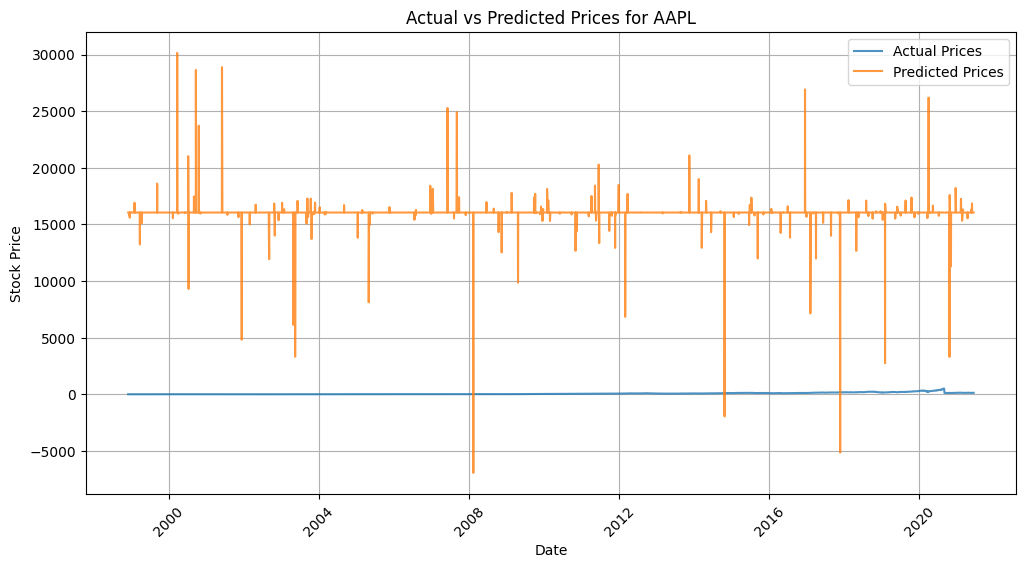

In [65]:
plt.figure(figsize=(12, 6))

# Slice the date column to match the predictions
dates = aapl_data['date'].iloc[sequence_length:].reset_index(drop=True)

plt.plot(dates, y_sequence_rescaled, label='Actual Prices', alpha=0.8)
plt.plot(dates, y_pred_rescaled, label='Predicted Prices', alpha=0.8)

plt.title('Actual vs Predicted Prices for AAPL')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [70]:
stock_data_tidy.head()

,ticker,date,close_adjusted,RSI,5_day_MA,10_day_MA,20_day_MA,50_day_MA,100_day_MA,200_day_MA,...,price_3_days_ago,price_4_days_ago,price_5_days_ago,price_10_days_ago,price_15_days_ago,price_30_days_ago,price_60_days_ago,price_90_days_ago,ticker_encoded,day_of_week
0,A,2000-09-05,3.928939e-08,0.848976,4.072033e-08,4.097881e-08,3.684831e-08,4.661724e-08,6.408939e-08,7.443236e-08,...,3.901617e-08,4.004550e-08,3.726897e-08,3.845711e-08,2.765619e-08,3.146831e-08,4.505201e-08,5.767632e-08,0,0.25
1,A,2000-09-06,3.813939e-08,0.791929,4.032506e-08,4.094505e-08,3.758626e-08,4.637094e-08,6.380585e-08,7.453230e-08,...,3.877473e-08,3.901617e-08,4.004550e-08,3.845711e-08,2.733857e-08,2.845034e-08,4.195151e-08,5.632937e-08,0,0.50
2,A,2000-09-07,3.933389e-08,0.783343,4.039094e-08,4.103822e-08,3.837228e-08,4.615019e-08,6.360916e-08,7.462372e-08,...,3.933389e-08,3.877473e-08,3.901617e-08,3.845711e-08,2.765619e-08,2.733857e-08,4.389566e-08,6.061801e-08,0,0.75
3,A,2000-09-08,3.766287e-08,0.572143,4.016038e-08,4.100446e-08,3.907749e-08,4.582055e-08,6.341777e-08,7.472055e-08,...,3.928939e-08,3.933389e-08,3.877473e-08,3.798058e-08,2.956220e-08,2.590899e-08,4.306337e-08,6.406156e-08,0,1.00
4,A,2000-09-11,3.607457e-08,0.397375,3.948450e-08,4.088631e-08,3.963889e-08,4.550913e-08,6.313187e-08,7.480088e-08,...,3.813939e-08,3.928939e-08,3.933389e-08,3.718643e-08,3.583949e-08,2.622670e-08,4.191337e-08,5.815284e-08,0,0.00


In [ ]:
plot_stock_chart(tst_data, ticker='TSLA')

In [ ]:
tst_data[(tst_data.ticker == 'TSLA') & (tst_data.close_adjusted > 1500)]

In [30]:
def create_lstm_model_2(sequence_length, num_features, lstm_units_1=128, lstm_units_2=64, dropout_rate=0.1):
    """
    Optimized LSTM model for stock price prediction.
    """
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    x = LSTM(lstm_units_1, return_sequences=True, name="lstm_layer_1")(numerical_input)
    x = Dropout(dropout_rate, name="dropout_1")(x)

    x = LSTM(lstm_units_2, return_sequences=False, name="lstm_layer_2")(x)

    x = Dense(32, activation='relu', name="dense_1")(x)

    x = Dense(16, activation='relu', name="dense_2")(x)

    output = Dense(1, activation='linear', name="output")(x)

    model = Model(inputs=numerical_input, outputs=output, name="Optimized_LSTM_Model")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [34]:
lstm_model_2 = create_lstm_model_2(sequence_length=30, num_features=len(numerical_columns))

In [35]:
lstm_model_2.fit(
    train_gen,
    steps_per_epoch=16000,
    epochs=50,
    callbacks=[early_stopping]
)

print("Training complete!")

lstm_model.save(google_drive_path + 'lstm_model_2_1.keras')

Предаденият резултат е скъсен до последните 5000 реда.
 7009/16000 ━━━━━━━━━━━━━━━━━━━━ 6:34 44ms/step - loss: 8.0836e-10 - mae: 1.1521e-05
 7016/16000 ━━━━━━━━━━━━━━━━━━━━ 6:34 44ms/step - loss: 8.0841e-10 - mae: 1.1521e-05 5734
 7042/16000 ━━━━━━━━━━━━━━━━━━━━ 6:33 44ms/step - loss: 8.0857e-10 - mae: 1.1520e-05
Ticker:  5735
 7081/16000 ━━━━━━━━━━━━━━━━━━━━ 6:29 44ms/step - loss: 8.0886e-10 - mae: 1.1519e-05
Ticker:  5736
 7087/16000 ━━━━━━━━━━━━━━━━━━━━ 6:31 44ms/step - loss: 8.0891e-10 - mae: 1.1519e-05
Ticker:  5737
 7126/16000 ━━━━━━━━━━━━━━━━━━━━ 6:28 44ms/step - loss: 8.0922e-10 - mae: 1.1519e-05
Ticker:  5738
 7136/16000 ━━━━━━━━━━━━━━━━━━━━ 6:29 44ms/step - loss: 8.0929e-10 - mae: 1.1519e-05
Ticker:  5739
 7177/16000 ━━━━━━━━━━━━━━━━━━━━ 6:26 44ms/step - loss: 8.0958e-10 - mae: 1.1519e-05
Ticker:  574
 7199/16000 ━━━━━━━━━━━━━━━━━━━━ 6:26 44ms/step - loss: 8.0972e-10 - mae: 1.1518e-05
Ticker:  5740
 7240/16000 ━━━━━━━━━━━━━━━━━━━━ 6:22 44ms/step - loss: 8.0996e-10 - mae: 1.15

It always predicts the same value... there is bias

In [80]:
lstm_model_2_2 = create_lstm_model_2(sequence_length=30, num_features=len(numerical_columns))

In [81]:
# Same model, but batch size is 32
lstm_model_2_2.fit(
    train_gen,
    steps_per_epoch=16000,
    epochs=50,
    callbacks=[early_stopping]
)

print("Training complete!")

lstm_model.save(google_drive_path + 'lstm_model_2_2.keras')


Ticker:  0
Epoch 1/50
  157/16000 ━━━━━━━━━━━━━━━━━━━━ 2:07 8ms/step - loss: 1.1965e-04 - mae: 0.0063
Ticker:  1
  184/16000 ━━━━━━━━━━━━━━━━━━━━ 2:07 8ms/step - loss: 1.0631e-04 - mae: 0.0058
Ticker:  10
  356/16000 ━━━━━━━━━━━━━━━━━━━━ 2:05 8ms/step - loss: 6.4368e-05 - mae: 0.0041
Ticker:  100
  370/16000 ━━━━━━━━━━━━━━━━━━━━ 2:05 8ms/step - loss: 6.2480e-05 - mae: 0.0040
Ticker:  1000
  544/16000 ━━━━━━━━━━━━━━━━━━━━ 2:02 8ms/step - loss: 4.6285e-05 - mae: 0.0033
Ticker:  1001
  723/16000 ━━━━━━━━━━━━━━━━━━━━ 2:00 8ms/step - loss: 3.6996e-05 - mae: 0.0028
Ticker:  1002
  900/16000 ━━━━━━━━━━━━━━━━━━━━ 1:59 8ms/step - loss: 3.1088e-05 - mae: 0.0025
Ticker:  1003
 1075/16000 ━━━━━━━━━━━━━━━━━━━━ 1:58 8ms/step - loss: 2.6967e-05 - mae: 0.0023
Ticker:  1004
 1228/16000 ━━━━━━━━━━━━━━━━━━━━ 1:56 8ms/step - loss: 2.4230e-05 - mae: 0.0021
Ticker:  1005
 1403/16000 ━━━━━━━━━━━━━━━━━━━━ 1:54 8ms/step - loss: 2.1757e-05 - mae: 0.0020
Ticker:  1008

Ticker:  101
 1584/16000 ━━━━━━━━━━━━━━━━━